# PART 1. Data-pre processing

<strong> Step #0 - Start the program by importing the libraries </strong>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
plt.style.use('fivethirtyeight')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import warnings
warnings.filterwarnings("ignore")
from math import sqrt

<strong>Step #1 - Reading the Data </strong> 

In [2]:
# Importing Training Set
dataset_train = pd.read_csv('https://raw.githubusercontent.com/zalven/covid-19-prediction-2021/main/covid_prediction_data/philippines_covid_cases.csv')
WINDOWS = 7
def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

moving_avg_new_cases = moving_average(dataset_train['new_cases'], WINDOWS)
moving_avg_deaths = moving_average(dataset_train['new_deaths'], WINDOWS)
moving_avg_total_cases =  moving_average(dataset_train['total_cases'], WINDOWS)

dataset_train['moving_average_new_cases'] = moving_avg_new_cases
dataset_train['moving_average_new_deaths'] = moving_avg_deaths
dataset_train['moving_average_total_cases'] = moving_avg_total_cases 


In [3]:
print("Size/Shape of the dataset: ",dataset_train.shape)
print("Checking for null values:\n",dataset_train.isnull().sum())
print("Checking Data-type of each column:\n",dataset_train.dtypes)

Size/Shape of the dataset:  (499, 54)
Checking for null values:
 iso_code                                  0
continent                                 0
location                                  0
date                                      0
total_cases                               0
new_cases                                 0
new_cases_smoothed                        0
total_deaths                              0
new_deaths                                0
new_deaths_smoothed                       0
total_cases_per_million                   0
new_cases_per_million                     0
new_cases_smoothed_per_million            0
total_deaths_per_million                  0
new_deaths_per_million                    0
new_deaths_smoothed_per_million           0
reproduction_rate                         0
new_tests                                 0
total_tests                               0
total_tests_per_thousand                  0
new_tests_per_thousand                    0
new_tests_s

In [4]:
# Select features (columns) to be involved intro training and predictions
predict_value = 'new_cases'       # Legend that we want to predict 
# Legends that support the legend we want to predict
cols = [
    "total_cases",
    "new_cases_smoothed",
    "total_cases_per_million",
    "new_cases_per_million",
    "new_cases_smoothed_per_million",
    "total_deaths_per_million",
    'moving_average_total_cases',
    "reproduction_rate",
    "new_tests",
    "total_tests",
    "total_tests_per_thousand",
    "new_tests_per_thousand",
    "new_tests_smoothed",
    "new_tests_smoothed_per_thousand",
    "positive_rate",
    "tests_per_case",
    "total_vaccinations",
    "people_vaccinated",
    "people_fully_vaccinated",
    "new_vaccinations",
    "new_vaccinations_smoothed",
    "total_vaccinations_per_hundred",
    "people_vaccinated_per_hundred",
    "people_fully_vaccinated_per_hundred",
    "new_vaccinations_smoothed_per_million",
    "stringency_index",
    "population",
    "population_density",
    "median_age",
    "aged_65_older",
    "aged_70_older"
]
n_future = 60                     # Number of days we want top predict into the future
n_past =  30                      # Number of past days we want to use to predict the future
n_starting_date = '2020-01-30'



In [5]:

# Generate columns 
cols.insert(0, predict_value)  

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['date'])
datelist_train = [dt.datetime.strptime(date,'%m/%d/%Y').date() for date in datelist_train]
dates = dataset_train['date']
future_forcast = np.array([i for i in range(len(dates)+n_future )]).reshape(-1, 1)
adjusted_dates = future_forcast[:-n_future ]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (499, 54)
All timestamps == 499
Featured selected: ['new_cases', 'total_cases', 'new_cases_smoothed', 'total_cases_per_million', 'new_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 'moving_average_total_cases', 'reproduction_rate', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations', 'new_vaccinations_smoothed', 'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred', 'new_vaccinations_smoothed_per_million', 'stringency_index', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older']


In [6]:
dataset_train.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality,moving_average_new_cases,moving_average_new_deaths,moving_average_total_cases
0,PHL,Asia,Philippines,1/30/2020,1,1,0.0,0,0,0.0,...,7.8,40.8,78.463,1,71.23,0.718,0.00,0.285714,0.142857,1.571429
1,PHL,Asia,Philippines,1/31/2020,1,0,0.0,0,0,0.0,...,7.8,40.8,78.463,1,71.23,0.718,2.83,0.142857,0.142857,1.714286
2,PHL,Asia,Philippines,2/1/2020,1,0,0.0,0,0,0.0,...,7.8,40.8,78.463,1,71.23,0.718,0.00,0.285714,0.142857,2.000000
3,PHL,Asia,Philippines,2/2/2020,2,1,0.0,1,1,0.0,...,7.8,40.8,78.463,1,71.23,0.718,0.00,0.285714,0.142857,2.285714
4,PHL,Asia,Philippines,2/3/2020,2,0,0.0,1,0,0.0,...,7.8,40.8,78.463,1,71.23,0.718,0.00,0.142857,0.000000,2.428571


In [7]:
dataset_train.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality,moving_average_new_cases,moving_average_new_deaths,moving_average_total_cases
494,PHL,Asia,Philippines,6/7/2021,1276004,6526,6529.000,21969,71,143.286,...,7.8,40.8,78.463,1,71.23,0.718,0.0,6174.200000,121.800000,1.287406e+06
495,PHL,Asia,Philippines,6/8/2021,1280773,4769,6472.286,22064,95,150.286,...,7.8,40.8,78.463,1,71.23,0.718,0.0,6086.250000,134.500000,1.290256e+06
496,PHL,Asia,Philippines,6/9/2021,1286217,5444,6500.143,22190,126,147.429,...,7.8,40.8,78.463,1,71.23,0.718,0.0,6525.333333,147.666667,1.293418e+06
497,PHL,Asia,Philippines,6/10/2021,1293687,7470,6541.143,22312,122,136.429,...,7.8,40.8,78.463,1,71.23,0.718,0.0,7066.000000,158.500000,1.297018e+06
498,PHL,Asia,Philippines,6/11/2021,1300349,6662,6430.286,22507,195,138.571,...,7.8,40.8,78.463,1,71.23,0.718,0.0,6662.000000,195.000000,1.300349e+06


<strong>Step #2 - Data pre processing </strong> 

In [8]:

dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        print( i, j )
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.to_numpy()

print('Shape of training set == {}.'.format(training_set.shape))
training_set


new_cases 0
new_cases 1
new_cases 2
new_cases 3
new_cases 4
new_cases 5
new_cases 6
new_cases 7
new_cases 8
new_cases 9
new_cases 10
new_cases 11
new_cases 12
new_cases 13
new_cases 14
new_cases 15
new_cases 16
new_cases 17
new_cases 18
new_cases 19
new_cases 20
new_cases 21
new_cases 22
new_cases 23
new_cases 24
new_cases 25
new_cases 26
new_cases 27
new_cases 28
new_cases 29
new_cases 30
new_cases 31
new_cases 32
new_cases 33
new_cases 34
new_cases 35
new_cases 36
new_cases 37
new_cases 38
new_cases 39
new_cases 40
new_cases 41
new_cases 42
new_cases 43
new_cases 44
new_cases 45
new_cases 46
new_cases 47
new_cases 48
new_cases 49
new_cases 50
new_cases 51
new_cases 52
new_cases 53
new_cases 54
new_cases 55
new_cases 56
new_cases 57
new_cases 58
new_cases 59
new_cases 60
new_cases 61
new_cases 62
new_cases 63
new_cases 64
new_cases 65
new_cases 66
new_cases 67
new_cases 68
new_cases 69
new_cases 70
new_cases 71
new_cases 72
new_cases 73
new_cases 74
new_cases 75
new_cases 76
new_cases

total_cases 94
total_cases 95
total_cases 96
total_cases 97
total_cases 98
total_cases 99
total_cases 100
total_cases 101
total_cases 102
total_cases 103
total_cases 104
total_cases 105
total_cases 106
total_cases 107
total_cases 108
total_cases 109
total_cases 110
total_cases 111
total_cases 112
total_cases 113
total_cases 114
total_cases 115
total_cases 116
total_cases 117
total_cases 118
total_cases 119
total_cases 120
total_cases 121
total_cases 122
total_cases 123
total_cases 124
total_cases 125
total_cases 126
total_cases 127
total_cases 128
total_cases 129
total_cases 130
total_cases 131
total_cases 132
total_cases 133
total_cases 134
total_cases 135
total_cases 136
total_cases 137
total_cases 138
total_cases 139
total_cases 140
total_cases 141
total_cases 142
total_cases 143
total_cases 144
total_cases 145
total_cases 146
total_cases 147
total_cases 148
total_cases 149
total_cases 150
total_cases 151
total_cases 152
total_cases 153
total_cases 154
total_cases 155
total_cases 15

new_cases_smoothed 81
new_cases_smoothed 82
new_cases_smoothed 83
new_cases_smoothed 84
new_cases_smoothed 85
new_cases_smoothed 86
new_cases_smoothed 87
new_cases_smoothed 88
new_cases_smoothed 89
new_cases_smoothed 90
new_cases_smoothed 91
new_cases_smoothed 92
new_cases_smoothed 93
new_cases_smoothed 94
new_cases_smoothed 95
new_cases_smoothed 96
new_cases_smoothed 97
new_cases_smoothed 98
new_cases_smoothed 99
new_cases_smoothed 100
new_cases_smoothed 101
new_cases_smoothed 102
new_cases_smoothed 103
new_cases_smoothed 104
new_cases_smoothed 105
new_cases_smoothed 106
new_cases_smoothed 107
new_cases_smoothed 108
new_cases_smoothed 109
new_cases_smoothed 110
new_cases_smoothed 111
new_cases_smoothed 112
new_cases_smoothed 113
new_cases_smoothed 114
new_cases_smoothed 115
new_cases_smoothed 116
new_cases_smoothed 117
new_cases_smoothed 118
new_cases_smoothed 119
new_cases_smoothed 120
new_cases_smoothed 121
new_cases_smoothed 122
new_cases_smoothed 123
new_cases_smoothed 124
new_cas

new_cases_smoothed 469
new_cases_smoothed 470
new_cases_smoothed 471
new_cases_smoothed 472
new_cases_smoothed 473
new_cases_smoothed 474
new_cases_smoothed 475
new_cases_smoothed 476
new_cases_smoothed 477
new_cases_smoothed 478
new_cases_smoothed 479
new_cases_smoothed 480
new_cases_smoothed 481
new_cases_smoothed 482
new_cases_smoothed 483
new_cases_smoothed 484
new_cases_smoothed 485
new_cases_smoothed 486
new_cases_smoothed 487
new_cases_smoothed 488
new_cases_smoothed 489
new_cases_smoothed 490
new_cases_smoothed 491
new_cases_smoothed 492
new_cases_smoothed 493
new_cases_smoothed 494
new_cases_smoothed 495
new_cases_smoothed 496
new_cases_smoothed 497
new_cases_smoothed 498
total_cases_per_million 0
total_cases_per_million 1
total_cases_per_million 2
total_cases_per_million 3
total_cases_per_million 4
total_cases_per_million 5
total_cases_per_million 6
total_cases_per_million 7
total_cases_per_million 8
total_cases_per_million 9
total_cases_per_million 10
total_cases_per_million

total_cases_per_million 279
total_cases_per_million 280
total_cases_per_million 281
total_cases_per_million 282
total_cases_per_million 283
total_cases_per_million 284
total_cases_per_million 285
total_cases_per_million 286
total_cases_per_million 287
total_cases_per_million 288
total_cases_per_million 289
total_cases_per_million 290
total_cases_per_million 291
total_cases_per_million 292
total_cases_per_million 293
total_cases_per_million 294
total_cases_per_million 295
total_cases_per_million 296
total_cases_per_million 297
total_cases_per_million 298
total_cases_per_million 299
total_cases_per_million 300
total_cases_per_million 301
total_cases_per_million 302
total_cases_per_million 303
total_cases_per_million 304
total_cases_per_million 305
total_cases_per_million 306
total_cases_per_million 307
total_cases_per_million 308
total_cases_per_million 309
total_cases_per_million 310
total_cases_per_million 311
total_cases_per_million 312
total_cases_per_million 313
total_cases_per_mill

new_cases_per_million 106
new_cases_per_million 107
new_cases_per_million 108
new_cases_per_million 109
new_cases_per_million 110
new_cases_per_million 111
new_cases_per_million 112
new_cases_per_million 113
new_cases_per_million 114
new_cases_per_million 115
new_cases_per_million 116
new_cases_per_million 117
new_cases_per_million 118
new_cases_per_million 119
new_cases_per_million 120
new_cases_per_million 121
new_cases_per_million 122
new_cases_per_million 123
new_cases_per_million 124
new_cases_per_million 125
new_cases_per_million 126
new_cases_per_million 127
new_cases_per_million 128
new_cases_per_million 129
new_cases_per_million 130
new_cases_per_million 131
new_cases_per_million 132
new_cases_per_million 133
new_cases_per_million 134
new_cases_per_million 135
new_cases_per_million 136
new_cases_per_million 137
new_cases_per_million 138
new_cases_per_million 139
new_cases_per_million 140
new_cases_per_million 141
new_cases_per_million 142
new_cases_per_million 143
new_cases_pe

new_cases_per_million 450
new_cases_per_million 451
new_cases_per_million 452
new_cases_per_million 453
new_cases_per_million 454
new_cases_per_million 455
new_cases_per_million 456
new_cases_per_million 457
new_cases_per_million 458
new_cases_per_million 459
new_cases_per_million 460
new_cases_per_million 461
new_cases_per_million 462
new_cases_per_million 463
new_cases_per_million 464
new_cases_per_million 465
new_cases_per_million 466
new_cases_per_million 467
new_cases_per_million 468
new_cases_per_million 469
new_cases_per_million 470
new_cases_per_million 471
new_cases_per_million 472
new_cases_per_million 473
new_cases_per_million 474
new_cases_per_million 475
new_cases_per_million 476
new_cases_per_million 477
new_cases_per_million 478
new_cases_per_million 479
new_cases_per_million 480
new_cases_per_million 481
new_cases_per_million 482
new_cases_per_million 483
new_cases_per_million 484
new_cases_per_million 485
new_cases_per_million 486
new_cases_per_million 487
new_cases_pe

new_cases_smoothed_per_million 205
new_cases_smoothed_per_million 206
new_cases_smoothed_per_million 207
new_cases_smoothed_per_million 208
new_cases_smoothed_per_million 209
new_cases_smoothed_per_million 210
new_cases_smoothed_per_million 211
new_cases_smoothed_per_million 212
new_cases_smoothed_per_million 213
new_cases_smoothed_per_million 214
new_cases_smoothed_per_million 215
new_cases_smoothed_per_million 216
new_cases_smoothed_per_million 217
new_cases_smoothed_per_million 218
new_cases_smoothed_per_million 219
new_cases_smoothed_per_million 220
new_cases_smoothed_per_million 221
new_cases_smoothed_per_million 222
new_cases_smoothed_per_million 223
new_cases_smoothed_per_million 224
new_cases_smoothed_per_million 225
new_cases_smoothed_per_million 226
new_cases_smoothed_per_million 227
new_cases_smoothed_per_million 228
new_cases_smoothed_per_million 229
new_cases_smoothed_per_million 230
new_cases_smoothed_per_million 231
new_cases_smoothed_per_million 232
new_cases_smoothed_p

new_cases_smoothed_per_million 485
new_cases_smoothed_per_million 486
new_cases_smoothed_per_million 487
new_cases_smoothed_per_million 488
new_cases_smoothed_per_million 489
new_cases_smoothed_per_million 490
new_cases_smoothed_per_million 491
new_cases_smoothed_per_million 492
new_cases_smoothed_per_million 493
new_cases_smoothed_per_million 494
new_cases_smoothed_per_million 495
new_cases_smoothed_per_million 496
new_cases_smoothed_per_million 497
new_cases_smoothed_per_million 498
total_deaths_per_million 0
total_deaths_per_million 1
total_deaths_per_million 2
total_deaths_per_million 3
total_deaths_per_million 4
total_deaths_per_million 5
total_deaths_per_million 6
total_deaths_per_million 7
total_deaths_per_million 8
total_deaths_per_million 9
total_deaths_per_million 10
total_deaths_per_million 11
total_deaths_per_million 12
total_deaths_per_million 13
total_deaths_per_million 14
total_deaths_per_million 15
total_deaths_per_million 16
total_deaths_per_million 17
total_deaths_per

total_deaths_per_million 284
total_deaths_per_million 285
total_deaths_per_million 286
total_deaths_per_million 287
total_deaths_per_million 288
total_deaths_per_million 289
total_deaths_per_million 290
total_deaths_per_million 291
total_deaths_per_million 292
total_deaths_per_million 293
total_deaths_per_million 294
total_deaths_per_million 295
total_deaths_per_million 296
total_deaths_per_million 297
total_deaths_per_million 298
total_deaths_per_million 299
total_deaths_per_million 300
total_deaths_per_million 301
total_deaths_per_million 302
total_deaths_per_million 303
total_deaths_per_million 304
total_deaths_per_million 305
total_deaths_per_million 306
total_deaths_per_million 307
total_deaths_per_million 308
total_deaths_per_million 309
total_deaths_per_million 310
total_deaths_per_million 311
total_deaths_per_million 312
total_deaths_per_million 313
total_deaths_per_million 314
total_deaths_per_million 315
total_deaths_per_million 316
total_deaths_per_million 317
total_deaths_p

moving_average_total_cases 83
moving_average_total_cases 84
moving_average_total_cases 85
moving_average_total_cases 86
moving_average_total_cases 87
moving_average_total_cases 88
moving_average_total_cases 89
moving_average_total_cases 90
moving_average_total_cases 91
moving_average_total_cases 92
moving_average_total_cases 93
moving_average_total_cases 94
moving_average_total_cases 95
moving_average_total_cases 96
moving_average_total_cases 97
moving_average_total_cases 98
moving_average_total_cases 99
moving_average_total_cases 100
moving_average_total_cases 101
moving_average_total_cases 102
moving_average_total_cases 103
moving_average_total_cases 104
moving_average_total_cases 105
moving_average_total_cases 106
moving_average_total_cases 107
moving_average_total_cases 108
moving_average_total_cases 109
moving_average_total_cases 110
moving_average_total_cases 111
moving_average_total_cases 112
moving_average_total_cases 113
moving_average_total_cases 114
moving_average_total_case

moving_average_total_cases 351
moving_average_total_cases 352
moving_average_total_cases 353
moving_average_total_cases 354
moving_average_total_cases 355
moving_average_total_cases 356
moving_average_total_cases 357
moving_average_total_cases 358
moving_average_total_cases 359
moving_average_total_cases 360
moving_average_total_cases 361
moving_average_total_cases 362
moving_average_total_cases 363
moving_average_total_cases 364
moving_average_total_cases 365
moving_average_total_cases 366
moving_average_total_cases 367
moving_average_total_cases 368
moving_average_total_cases 369
moving_average_total_cases 370
moving_average_total_cases 371
moving_average_total_cases 372
moving_average_total_cases 373
moving_average_total_cases 374
moving_average_total_cases 375
moving_average_total_cases 376
moving_average_total_cases 377
moving_average_total_cases 378
moving_average_total_cases 379
moving_average_total_cases 380
moving_average_total_cases 381
moving_average_total_cases 382
moving_a

reproduction_rate 192
reproduction_rate 193
reproduction_rate 194
reproduction_rate 195
reproduction_rate 196
reproduction_rate 197
reproduction_rate 198
reproduction_rate 199
reproduction_rate 200
reproduction_rate 201
reproduction_rate 202
reproduction_rate 203
reproduction_rate 204
reproduction_rate 205
reproduction_rate 206
reproduction_rate 207
reproduction_rate 208
reproduction_rate 209
reproduction_rate 210
reproduction_rate 211
reproduction_rate 212
reproduction_rate 213
reproduction_rate 214
reproduction_rate 215
reproduction_rate 216
reproduction_rate 217
reproduction_rate 218
reproduction_rate 219
reproduction_rate 220
reproduction_rate 221
reproduction_rate 222
reproduction_rate 223
reproduction_rate 224
reproduction_rate 225
reproduction_rate 226
reproduction_rate 227
reproduction_rate 228
reproduction_rate 229
reproduction_rate 230
reproduction_rate 231
reproduction_rate 232
reproduction_rate 233
reproduction_rate 234
reproduction_rate 235
reproduction_rate 236
reproducti

new_tests 134
new_tests 135
new_tests 136
new_tests 137
new_tests 138
new_tests 139
new_tests 140
new_tests 141
new_tests 142
new_tests 143
new_tests 144
new_tests 145
new_tests 146
new_tests 147
new_tests 148
new_tests 149
new_tests 150
new_tests 151
new_tests 152
new_tests 153
new_tests 154
new_tests 155
new_tests 156
new_tests 157
new_tests 158
new_tests 159
new_tests 160
new_tests 161
new_tests 162
new_tests 163
new_tests 164
new_tests 165
new_tests 166
new_tests 167
new_tests 168
new_tests 169
new_tests 170
new_tests 171
new_tests 172
new_tests 173
new_tests 174
new_tests 175
new_tests 176
new_tests 177
new_tests 178
new_tests 179
new_tests 180
new_tests 181
new_tests 182
new_tests 183
new_tests 184
new_tests 185
new_tests 186
new_tests 187
new_tests 188
new_tests 189
new_tests 190
new_tests 191
new_tests 192
new_tests 193
new_tests 194
new_tests 195
new_tests 196
new_tests 197
new_tests 198
new_tests 199
new_tests 200
new_tests 201
new_tests 202
new_tests 203
new_tests 204
new_te

total_tests 202
total_tests 203
total_tests 204
total_tests 205
total_tests 206
total_tests 207
total_tests 208
total_tests 209
total_tests 210
total_tests 211
total_tests 212
total_tests 213
total_tests 214
total_tests 215
total_tests 216
total_tests 217
total_tests 218
total_tests 219
total_tests 220
total_tests 221
total_tests 222
total_tests 223
total_tests 224
total_tests 225
total_tests 226
total_tests 227
total_tests 228
total_tests 229
total_tests 230
total_tests 231
total_tests 232
total_tests 233
total_tests 234
total_tests 235
total_tests 236
total_tests 237
total_tests 238
total_tests 239
total_tests 240
total_tests 241
total_tests 242
total_tests 243
total_tests 244
total_tests 245
total_tests 246
total_tests 247
total_tests 248
total_tests 249
total_tests 250
total_tests 251
total_tests 252
total_tests 253
total_tests 254
total_tests 255
total_tests 256
total_tests 257
total_tests 258
total_tests 259
total_tests 260
total_tests 261
total_tests 262
total_tests 263
total_te

total_tests_per_thousand 150
total_tests_per_thousand 151
total_tests_per_thousand 152
total_tests_per_thousand 153
total_tests_per_thousand 154
total_tests_per_thousand 155
total_tests_per_thousand 156
total_tests_per_thousand 157
total_tests_per_thousand 158
total_tests_per_thousand 159
total_tests_per_thousand 160
total_tests_per_thousand 161
total_tests_per_thousand 162
total_tests_per_thousand 163
total_tests_per_thousand 164
total_tests_per_thousand 165
total_tests_per_thousand 166
total_tests_per_thousand 167
total_tests_per_thousand 168
total_tests_per_thousand 169
total_tests_per_thousand 170
total_tests_per_thousand 171
total_tests_per_thousand 172
total_tests_per_thousand 173
total_tests_per_thousand 174
total_tests_per_thousand 175
total_tests_per_thousand 176
total_tests_per_thousand 177
total_tests_per_thousand 178
total_tests_per_thousand 179
total_tests_per_thousand 180
total_tests_per_thousand 181
total_tests_per_thousand 182
total_tests_per_thousand 183
total_tests_pe

total_tests_per_thousand 478
total_tests_per_thousand 479
total_tests_per_thousand 480
total_tests_per_thousand 481
total_tests_per_thousand 482
total_tests_per_thousand 483
total_tests_per_thousand 484
total_tests_per_thousand 485
total_tests_per_thousand 486
total_tests_per_thousand 487
total_tests_per_thousand 488
total_tests_per_thousand 489
total_tests_per_thousand 490
total_tests_per_thousand 491
total_tests_per_thousand 492
total_tests_per_thousand 493
total_tests_per_thousand 494
total_tests_per_thousand 495
total_tests_per_thousand 496
total_tests_per_thousand 497
total_tests_per_thousand 498
new_tests_per_thousand 0
new_tests_per_thousand 1
new_tests_per_thousand 2
new_tests_per_thousand 3
new_tests_per_thousand 4
new_tests_per_thousand 5
new_tests_per_thousand 6
new_tests_per_thousand 7
new_tests_per_thousand 8
new_tests_per_thousand 9
new_tests_per_thousand 10
new_tests_per_thousand 11
new_tests_per_thousand 12
new_tests_per_thousand 13
new_tests_per_thousand 14
new_tests_p

new_tests_per_thousand 297
new_tests_per_thousand 298
new_tests_per_thousand 299
new_tests_per_thousand 300
new_tests_per_thousand 301
new_tests_per_thousand 302
new_tests_per_thousand 303
new_tests_per_thousand 304
new_tests_per_thousand 305
new_tests_per_thousand 306
new_tests_per_thousand 307
new_tests_per_thousand 308
new_tests_per_thousand 309
new_tests_per_thousand 310
new_tests_per_thousand 311
new_tests_per_thousand 312
new_tests_per_thousand 313
new_tests_per_thousand 314
new_tests_per_thousand 315
new_tests_per_thousand 316
new_tests_per_thousand 317
new_tests_per_thousand 318
new_tests_per_thousand 319
new_tests_per_thousand 320
new_tests_per_thousand 321
new_tests_per_thousand 322
new_tests_per_thousand 323
new_tests_per_thousand 324
new_tests_per_thousand 325
new_tests_per_thousand 326
new_tests_per_thousand 327
new_tests_per_thousand 328
new_tests_per_thousand 329
new_tests_per_thousand 330
new_tests_per_thousand 331
new_tests_per_thousand 332
new_tests_per_thousand 333
n

new_tests_smoothed 210
new_tests_smoothed 211
new_tests_smoothed 212
new_tests_smoothed 213
new_tests_smoothed 214
new_tests_smoothed 215
new_tests_smoothed 216
new_tests_smoothed 217
new_tests_smoothed 218
new_tests_smoothed 219
new_tests_smoothed 220
new_tests_smoothed 221
new_tests_smoothed 222
new_tests_smoothed 223
new_tests_smoothed 224
new_tests_smoothed 225
new_tests_smoothed 226
new_tests_smoothed 227
new_tests_smoothed 228
new_tests_smoothed 229
new_tests_smoothed 230
new_tests_smoothed 231
new_tests_smoothed 232
new_tests_smoothed 233
new_tests_smoothed 234
new_tests_smoothed 235
new_tests_smoothed 236
new_tests_smoothed 237
new_tests_smoothed 238
new_tests_smoothed 239
new_tests_smoothed 240
new_tests_smoothed 241
new_tests_smoothed 242
new_tests_smoothed 243
new_tests_smoothed 244
new_tests_smoothed 245
new_tests_smoothed 246
new_tests_smoothed 247
new_tests_smoothed 248
new_tests_smoothed 249
new_tests_smoothed 250
new_tests_smoothed 251
new_tests_smoothed 252
new_tests_s

new_tests_smoothed_per_thousand 148
new_tests_smoothed_per_thousand 149
new_tests_smoothed_per_thousand 150
new_tests_smoothed_per_thousand 151
new_tests_smoothed_per_thousand 152
new_tests_smoothed_per_thousand 153
new_tests_smoothed_per_thousand 154
new_tests_smoothed_per_thousand 155
new_tests_smoothed_per_thousand 156
new_tests_smoothed_per_thousand 157
new_tests_smoothed_per_thousand 158
new_tests_smoothed_per_thousand 159
new_tests_smoothed_per_thousand 160
new_tests_smoothed_per_thousand 161
new_tests_smoothed_per_thousand 162
new_tests_smoothed_per_thousand 163
new_tests_smoothed_per_thousand 164
new_tests_smoothed_per_thousand 165
new_tests_smoothed_per_thousand 166
new_tests_smoothed_per_thousand 167
new_tests_smoothed_per_thousand 168
new_tests_smoothed_per_thousand 169
new_tests_smoothed_per_thousand 170
new_tests_smoothed_per_thousand 171
new_tests_smoothed_per_thousand 172
new_tests_smoothed_per_thousand 173
new_tests_smoothed_per_thousand 174
new_tests_smoothed_per_thous

new_tests_smoothed_per_thousand 418
new_tests_smoothed_per_thousand 419
new_tests_smoothed_per_thousand 420
new_tests_smoothed_per_thousand 421
new_tests_smoothed_per_thousand 422
new_tests_smoothed_per_thousand 423
new_tests_smoothed_per_thousand 424
new_tests_smoothed_per_thousand 425
new_tests_smoothed_per_thousand 426
new_tests_smoothed_per_thousand 427
new_tests_smoothed_per_thousand 428
new_tests_smoothed_per_thousand 429
new_tests_smoothed_per_thousand 430
new_tests_smoothed_per_thousand 431
new_tests_smoothed_per_thousand 432
new_tests_smoothed_per_thousand 433
new_tests_smoothed_per_thousand 434
new_tests_smoothed_per_thousand 435
new_tests_smoothed_per_thousand 436
new_tests_smoothed_per_thousand 437
new_tests_smoothed_per_thousand 438
new_tests_smoothed_per_thousand 439
new_tests_smoothed_per_thousand 440
new_tests_smoothed_per_thousand 441
new_tests_smoothed_per_thousand 442
new_tests_smoothed_per_thousand 443
new_tests_smoothed_per_thousand 444
new_tests_smoothed_per_thous

positive_rate 311
positive_rate 312
positive_rate 313
positive_rate 314
positive_rate 315
positive_rate 316
positive_rate 317
positive_rate 318
positive_rate 319
positive_rate 320
positive_rate 321
positive_rate 322
positive_rate 323
positive_rate 324
positive_rate 325
positive_rate 326
positive_rate 327
positive_rate 328
positive_rate 329
positive_rate 330
positive_rate 331
positive_rate 332
positive_rate 333
positive_rate 334
positive_rate 335
positive_rate 336
positive_rate 337
positive_rate 338
positive_rate 339
positive_rate 340
positive_rate 341
positive_rate 342
positive_rate 343
positive_rate 344
positive_rate 345
positive_rate 346
positive_rate 347
positive_rate 348
positive_rate 349
positive_rate 350
positive_rate 351
positive_rate 352
positive_rate 353
positive_rate 354
positive_rate 355
positive_rate 356
positive_rate 357
positive_rate 358
positive_rate 359
positive_rate 360
positive_rate 361
positive_rate 362
positive_rate 363
positive_rate 364
positive_rate 365
positive_r

tests_per_case 266
tests_per_case 267
tests_per_case 268
tests_per_case 269
tests_per_case 270
tests_per_case 271
tests_per_case 272
tests_per_case 273
tests_per_case 274
tests_per_case 275
tests_per_case 276
tests_per_case 277
tests_per_case 278
tests_per_case 279
tests_per_case 280
tests_per_case 281
tests_per_case 282
tests_per_case 283
tests_per_case 284
tests_per_case 285
tests_per_case 286
tests_per_case 287
tests_per_case 288
tests_per_case 289
tests_per_case 290
tests_per_case 291
tests_per_case 292
tests_per_case 293
tests_per_case 294
tests_per_case 295
tests_per_case 296
tests_per_case 297
tests_per_case 298
tests_per_case 299
tests_per_case 300
tests_per_case 301
tests_per_case 302
tests_per_case 303
tests_per_case 304
tests_per_case 305
tests_per_case 306
tests_per_case 307
tests_per_case 308
tests_per_case 309
tests_per_case 310
tests_per_case 311
tests_per_case 312
tests_per_case 313
tests_per_case 314
tests_per_case 315
tests_per_case 316
tests_per_case 317
tests_per_ca

total_vaccinations 206
total_vaccinations 207
total_vaccinations 208
total_vaccinations 209
total_vaccinations 210
total_vaccinations 211
total_vaccinations 212
total_vaccinations 213
total_vaccinations 214
total_vaccinations 215
total_vaccinations 216
total_vaccinations 217
total_vaccinations 218
total_vaccinations 219
total_vaccinations 220
total_vaccinations 221
total_vaccinations 222
total_vaccinations 223
total_vaccinations 224
total_vaccinations 225
total_vaccinations 226
total_vaccinations 227
total_vaccinations 228
total_vaccinations 229
total_vaccinations 230
total_vaccinations 231
total_vaccinations 232
total_vaccinations 233
total_vaccinations 234
total_vaccinations 235
total_vaccinations 236
total_vaccinations 237
total_vaccinations 238
total_vaccinations 239
total_vaccinations 240
total_vaccinations 241
total_vaccinations 242
total_vaccinations 243
total_vaccinations 244
total_vaccinations 245
total_vaccinations 246
total_vaccinations 247
total_vaccinations 248
total_vacci

people_vaccinated 82
people_vaccinated 83
people_vaccinated 84
people_vaccinated 85
people_vaccinated 86
people_vaccinated 87
people_vaccinated 88
people_vaccinated 89
people_vaccinated 90
people_vaccinated 91
people_vaccinated 92
people_vaccinated 93
people_vaccinated 94
people_vaccinated 95
people_vaccinated 96
people_vaccinated 97
people_vaccinated 98
people_vaccinated 99
people_vaccinated 100
people_vaccinated 101
people_vaccinated 102
people_vaccinated 103
people_vaccinated 104
people_vaccinated 105
people_vaccinated 106
people_vaccinated 107
people_vaccinated 108
people_vaccinated 109
people_vaccinated 110
people_vaccinated 111
people_vaccinated 112
people_vaccinated 113
people_vaccinated 114
people_vaccinated 115
people_vaccinated 116
people_vaccinated 117
people_vaccinated 118
people_vaccinated 119
people_vaccinated 120
people_vaccinated 121
people_vaccinated 122
people_vaccinated 123
people_vaccinated 124
people_vaccinated 125
people_vaccinated 126
people_vaccinated 127
people

people_vaccinated 473
people_vaccinated 474
people_vaccinated 475
people_vaccinated 476
people_vaccinated 477
people_vaccinated 478
people_vaccinated 479
people_vaccinated 480
people_vaccinated 481
people_vaccinated 482
people_vaccinated 483
people_vaccinated 484
people_vaccinated 485
people_vaccinated 486
people_vaccinated 487
people_vaccinated 488
people_vaccinated 489
people_vaccinated 490
people_vaccinated 491
people_vaccinated 492
people_vaccinated 493
people_vaccinated 494
people_vaccinated 495
people_vaccinated 496
people_vaccinated 497
people_vaccinated 498
people_fully_vaccinated 0
people_fully_vaccinated 1
people_fully_vaccinated 2
people_fully_vaccinated 3
people_fully_vaccinated 4
people_fully_vaccinated 5
people_fully_vaccinated 6
people_fully_vaccinated 7
people_fully_vaccinated 8
people_fully_vaccinated 9
people_fully_vaccinated 10
people_fully_vaccinated 11
people_fully_vaccinated 12
people_fully_vaccinated 13
people_fully_vaccinated 14
people_fully_vaccinated 15
people

people_fully_vaccinated 359
people_fully_vaccinated 360
people_fully_vaccinated 361
people_fully_vaccinated 362
people_fully_vaccinated 363
people_fully_vaccinated 364
people_fully_vaccinated 365
people_fully_vaccinated 366
people_fully_vaccinated 367
people_fully_vaccinated 368
people_fully_vaccinated 369
people_fully_vaccinated 370
people_fully_vaccinated 371
people_fully_vaccinated 372
people_fully_vaccinated 373
people_fully_vaccinated 374
people_fully_vaccinated 375
people_fully_vaccinated 376
people_fully_vaccinated 377
people_fully_vaccinated 378
people_fully_vaccinated 379
people_fully_vaccinated 380
people_fully_vaccinated 381
people_fully_vaccinated 382
people_fully_vaccinated 383
people_fully_vaccinated 384
people_fully_vaccinated 385
people_fully_vaccinated 386
people_fully_vaccinated 387
people_fully_vaccinated 388
people_fully_vaccinated 389
people_fully_vaccinated 390
people_fully_vaccinated 391
people_fully_vaccinated 392
people_fully_vaccinated 393
people_fully_vaccina

new_vaccinations 285
new_vaccinations 286
new_vaccinations 287
new_vaccinations 288
new_vaccinations 289
new_vaccinations 290
new_vaccinations 291
new_vaccinations 292
new_vaccinations 293
new_vaccinations 294
new_vaccinations 295
new_vaccinations 296
new_vaccinations 297
new_vaccinations 298
new_vaccinations 299
new_vaccinations 300
new_vaccinations 301
new_vaccinations 302
new_vaccinations 303
new_vaccinations 304
new_vaccinations 305
new_vaccinations 306
new_vaccinations 307
new_vaccinations 308
new_vaccinations 309
new_vaccinations 310
new_vaccinations 311
new_vaccinations 312
new_vaccinations 313
new_vaccinations 314
new_vaccinations 315
new_vaccinations 316
new_vaccinations 317
new_vaccinations 318
new_vaccinations 319
new_vaccinations 320
new_vaccinations 321
new_vaccinations 322
new_vaccinations 323
new_vaccinations 324
new_vaccinations 325
new_vaccinations 326
new_vaccinations 327
new_vaccinations 328
new_vaccinations 329
new_vaccinations 330
new_vaccinations 331
new_vaccinati

new_vaccinations_smoothed 223
new_vaccinations_smoothed 224
new_vaccinations_smoothed 225
new_vaccinations_smoothed 226
new_vaccinations_smoothed 227
new_vaccinations_smoothed 228
new_vaccinations_smoothed 229
new_vaccinations_smoothed 230
new_vaccinations_smoothed 231
new_vaccinations_smoothed 232
new_vaccinations_smoothed 233
new_vaccinations_smoothed 234
new_vaccinations_smoothed 235
new_vaccinations_smoothed 236
new_vaccinations_smoothed 237
new_vaccinations_smoothed 238
new_vaccinations_smoothed 239
new_vaccinations_smoothed 240
new_vaccinations_smoothed 241
new_vaccinations_smoothed 242
new_vaccinations_smoothed 243
new_vaccinations_smoothed 244
new_vaccinations_smoothed 245
new_vaccinations_smoothed 246
new_vaccinations_smoothed 247
new_vaccinations_smoothed 248
new_vaccinations_smoothed 249
new_vaccinations_smoothed 250
new_vaccinations_smoothed 251
new_vaccinations_smoothed 252
new_vaccinations_smoothed 253
new_vaccinations_smoothed 254
new_vaccinations_smoothed 255
new_vaccin

total_vaccinations_per_hundred 142
total_vaccinations_per_hundred 143
total_vaccinations_per_hundred 144
total_vaccinations_per_hundred 145
total_vaccinations_per_hundred 146
total_vaccinations_per_hundred 147
total_vaccinations_per_hundred 148
total_vaccinations_per_hundred 149
total_vaccinations_per_hundred 150
total_vaccinations_per_hundred 151
total_vaccinations_per_hundred 152
total_vaccinations_per_hundred 153
total_vaccinations_per_hundred 154
total_vaccinations_per_hundred 155
total_vaccinations_per_hundred 156
total_vaccinations_per_hundred 157
total_vaccinations_per_hundred 158
total_vaccinations_per_hundred 159
total_vaccinations_per_hundred 160
total_vaccinations_per_hundred 161
total_vaccinations_per_hundred 162
total_vaccinations_per_hundred 163
total_vaccinations_per_hundred 164
total_vaccinations_per_hundred 165
total_vaccinations_per_hundred 166
total_vaccinations_per_hundred 167
total_vaccinations_per_hundred 168
total_vaccinations_per_hundred 169
total_vaccinations_p

total_vaccinations_per_hundred 384
total_vaccinations_per_hundred 385
total_vaccinations_per_hundred 386
total_vaccinations_per_hundred 387
total_vaccinations_per_hundred 388
total_vaccinations_per_hundred 389
total_vaccinations_per_hundred 390
total_vaccinations_per_hundred 391
total_vaccinations_per_hundred 392
total_vaccinations_per_hundred 393
total_vaccinations_per_hundred 394
total_vaccinations_per_hundred 395
total_vaccinations_per_hundred 396
total_vaccinations_per_hundred 397
total_vaccinations_per_hundred 398
total_vaccinations_per_hundred 399
total_vaccinations_per_hundred 400
total_vaccinations_per_hundred 401
total_vaccinations_per_hundred 402
total_vaccinations_per_hundred 403
total_vaccinations_per_hundred 404
total_vaccinations_per_hundred 405
total_vaccinations_per_hundred 406
total_vaccinations_per_hundred 407
total_vaccinations_per_hundred 408
total_vaccinations_per_hundred 409
total_vaccinations_per_hundred 410
total_vaccinations_per_hundred 411
total_vaccinations_p

people_vaccinated_per_hundred 197
people_vaccinated_per_hundred 198
people_vaccinated_per_hundred 199
people_vaccinated_per_hundred 200
people_vaccinated_per_hundred 201
people_vaccinated_per_hundred 202
people_vaccinated_per_hundred 203
people_vaccinated_per_hundred 204
people_vaccinated_per_hundred 205
people_vaccinated_per_hundred 206
people_vaccinated_per_hundred 207
people_vaccinated_per_hundred 208
people_vaccinated_per_hundred 209
people_vaccinated_per_hundred 210
people_vaccinated_per_hundred 211
people_vaccinated_per_hundred 212
people_vaccinated_per_hundred 213
people_vaccinated_per_hundred 214
people_vaccinated_per_hundred 215
people_vaccinated_per_hundred 216
people_vaccinated_per_hundred 217
people_vaccinated_per_hundred 218
people_vaccinated_per_hundred 219
people_vaccinated_per_hundred 220
people_vaccinated_per_hundred 221
people_vaccinated_per_hundred 222
people_vaccinated_per_hundred 223
people_vaccinated_per_hundred 224
people_vaccinated_per_hundred 225
people_vaccina

people_fully_vaccinated_per_hundred 4
people_fully_vaccinated_per_hundred 5
people_fully_vaccinated_per_hundred 6
people_fully_vaccinated_per_hundred 7
people_fully_vaccinated_per_hundred 8
people_fully_vaccinated_per_hundred 9
people_fully_vaccinated_per_hundred 10
people_fully_vaccinated_per_hundred 11
people_fully_vaccinated_per_hundred 12
people_fully_vaccinated_per_hundred 13
people_fully_vaccinated_per_hundred 14
people_fully_vaccinated_per_hundred 15
people_fully_vaccinated_per_hundred 16
people_fully_vaccinated_per_hundred 17
people_fully_vaccinated_per_hundred 18
people_fully_vaccinated_per_hundred 19
people_fully_vaccinated_per_hundred 20
people_fully_vaccinated_per_hundred 21
people_fully_vaccinated_per_hundred 22
people_fully_vaccinated_per_hundred 23
people_fully_vaccinated_per_hundred 24
people_fully_vaccinated_per_hundred 25
people_fully_vaccinated_per_hundred 26
people_fully_vaccinated_per_hundred 27
people_fully_vaccinated_per_hundred 28
people_fully_vaccinated_per_hun

people_fully_vaccinated_per_hundred 223
people_fully_vaccinated_per_hundred 224
people_fully_vaccinated_per_hundred 225
people_fully_vaccinated_per_hundred 226
people_fully_vaccinated_per_hundred 227
people_fully_vaccinated_per_hundred 228
people_fully_vaccinated_per_hundred 229
people_fully_vaccinated_per_hundred 230
people_fully_vaccinated_per_hundred 231
people_fully_vaccinated_per_hundred 232
people_fully_vaccinated_per_hundred 233
people_fully_vaccinated_per_hundred 234
people_fully_vaccinated_per_hundred 235
people_fully_vaccinated_per_hundred 236
people_fully_vaccinated_per_hundred 237
people_fully_vaccinated_per_hundred 238
people_fully_vaccinated_per_hundred 239
people_fully_vaccinated_per_hundred 240
people_fully_vaccinated_per_hundred 241
people_fully_vaccinated_per_hundred 242
people_fully_vaccinated_per_hundred 243
people_fully_vaccinated_per_hundred 244
people_fully_vaccinated_per_hundred 245
people_fully_vaccinated_per_hundred 246
people_fully_vaccinated_per_hundred 247


people_fully_vaccinated_per_hundred 496
people_fully_vaccinated_per_hundred 497
people_fully_vaccinated_per_hundred 498
new_vaccinations_smoothed_per_million 0
new_vaccinations_smoothed_per_million 1
new_vaccinations_smoothed_per_million 2
new_vaccinations_smoothed_per_million 3
new_vaccinations_smoothed_per_million 4
new_vaccinations_smoothed_per_million 5
new_vaccinations_smoothed_per_million 6
new_vaccinations_smoothed_per_million 7
new_vaccinations_smoothed_per_million 8
new_vaccinations_smoothed_per_million 9
new_vaccinations_smoothed_per_million 10
new_vaccinations_smoothed_per_million 11
new_vaccinations_smoothed_per_million 12
new_vaccinations_smoothed_per_million 13
new_vaccinations_smoothed_per_million 14
new_vaccinations_smoothed_per_million 15
new_vaccinations_smoothed_per_million 16
new_vaccinations_smoothed_per_million 17
new_vaccinations_smoothed_per_million 18
new_vaccinations_smoothed_per_million 19
new_vaccinations_smoothed_per_million 20
new_vaccinations_smoothed_per

new_vaccinations_smoothed_per_million 311
new_vaccinations_smoothed_per_million 312
new_vaccinations_smoothed_per_million 313
new_vaccinations_smoothed_per_million 314
new_vaccinations_smoothed_per_million 315
new_vaccinations_smoothed_per_million 316
new_vaccinations_smoothed_per_million 317
new_vaccinations_smoothed_per_million 318
new_vaccinations_smoothed_per_million 319
new_vaccinations_smoothed_per_million 320
new_vaccinations_smoothed_per_million 321
new_vaccinations_smoothed_per_million 322
new_vaccinations_smoothed_per_million 323
new_vaccinations_smoothed_per_million 324
new_vaccinations_smoothed_per_million 325
new_vaccinations_smoothed_per_million 326
new_vaccinations_smoothed_per_million 327
new_vaccinations_smoothed_per_million 328
new_vaccinations_smoothed_per_million 329
new_vaccinations_smoothed_per_million 330
new_vaccinations_smoothed_per_million 331
new_vaccinations_smoothed_per_million 332
new_vaccinations_smoothed_per_million 333
new_vaccinations_smoothed_per_mill

stringency_index 57
stringency_index 58
stringency_index 59
stringency_index 60
stringency_index 61
stringency_index 62
stringency_index 63
stringency_index 64
stringency_index 65
stringency_index 66
stringency_index 67
stringency_index 68
stringency_index 69
stringency_index 70
stringency_index 71
stringency_index 72
stringency_index 73
stringency_index 74
stringency_index 75
stringency_index 76
stringency_index 77
stringency_index 78
stringency_index 79
stringency_index 80
stringency_index 81
stringency_index 82
stringency_index 83
stringency_index 84
stringency_index 85
stringency_index 86
stringency_index 87
stringency_index 88
stringency_index 89
stringency_index 90
stringency_index 91
stringency_index 92
stringency_index 93
stringency_index 94
stringency_index 95
stringency_index 96
stringency_index 97
stringency_index 98
stringency_index 99
stringency_index 100
stringency_index 101
stringency_index 102
stringency_index 103
stringency_index 104
stringency_index 105
stringency_ind

population 33
population 34
population 35
population 36
population 37
population 38
population 39
population 40
population 41
population 42
population 43
population 44
population 45
population 46
population 47
population 48
population 49
population 50
population 51
population 52
population 53
population 54
population 55
population 56
population 57
population 58
population 59
population 60
population 61
population 62
population 63
population 64
population 65
population 66
population 67
population 68
population 69
population 70
population 71
population 72
population 73
population 74
population 75
population 76
population 77
population 78
population 79
population 80
population 81
population 82
population 83
population 84
population 85
population 86
population 87
population 88
population 89
population 90
population 91
population 92
population 93
population 94
population 95
population 96
population 97
population 98
population 99
population 100
population 101
population 102
population 103
po

population_density 137
population_density 138
population_density 139
population_density 140
population_density 141
population_density 142
population_density 143
population_density 144
population_density 145
population_density 146
population_density 147
population_density 148
population_density 149
population_density 150
population_density 151
population_density 152
population_density 153
population_density 154
population_density 155
population_density 156
population_density 157
population_density 158
population_density 159
population_density 160
population_density 161
population_density 162
population_density 163
population_density 164
population_density 165
population_density 166
population_density 167
population_density 168
population_density 169
population_density 170
population_density 171
population_density 172
population_density 173
population_density 174
population_density 175
population_density 176
population_density 177
population_density 178
population_density 179
population_

median_age 87
median_age 88
median_age 89
median_age 90
median_age 91
median_age 92
median_age 93
median_age 94
median_age 95
median_age 96
median_age 97
median_age 98
median_age 99
median_age 100
median_age 101
median_age 102
median_age 103
median_age 104
median_age 105
median_age 106
median_age 107
median_age 108
median_age 109
median_age 110
median_age 111
median_age 112
median_age 113
median_age 114
median_age 115
median_age 116
median_age 117
median_age 118
median_age 119
median_age 120
median_age 121
median_age 122
median_age 123
median_age 124
median_age 125
median_age 126
median_age 127
median_age 128
median_age 129
median_age 130
median_age 131
median_age 132
median_age 133
median_age 134
median_age 135
median_age 136
median_age 137
median_age 138
median_age 139
median_age 140
median_age 141
median_age 142
median_age 143
median_age 144
median_age 145
median_age 146
median_age 147
median_age 148
median_age 149
median_age 150
median_age 151
median_age 152
median_age 153
median_a

aged_65_older 259
aged_65_older 260
aged_65_older 261
aged_65_older 262
aged_65_older 263
aged_65_older 264
aged_65_older 265
aged_65_older 266
aged_65_older 267
aged_65_older 268
aged_65_older 269
aged_65_older 270
aged_65_older 271
aged_65_older 272
aged_65_older 273
aged_65_older 274
aged_65_older 275
aged_65_older 276
aged_65_older 277
aged_65_older 278
aged_65_older 279
aged_65_older 280
aged_65_older 281
aged_65_older 282
aged_65_older 283
aged_65_older 284
aged_65_older 285
aged_65_older 286
aged_65_older 287
aged_65_older 288
aged_65_older 289
aged_65_older 290
aged_65_older 291
aged_65_older 292
aged_65_older 293
aged_65_older 294
aged_65_older 295
aged_65_older 296
aged_65_older 297
aged_65_older 298
aged_65_older 299
aged_65_older 300
aged_65_older 301
aged_65_older 302
aged_65_older 303
aged_65_older 304
aged_65_older 305
aged_65_older 306
aged_65_older 307
aged_65_older 308
aged_65_older 309
aged_65_older 310
aged_65_older 311
aged_65_older 312
aged_65_older 313
aged_65_ol

aged_70_older 240
aged_70_older 241
aged_70_older 242
aged_70_older 243
aged_70_older 244
aged_70_older 245
aged_70_older 246
aged_70_older 247
aged_70_older 248
aged_70_older 249
aged_70_older 250
aged_70_older 251
aged_70_older 252
aged_70_older 253
aged_70_older 254
aged_70_older 255
aged_70_older 256
aged_70_older 257
aged_70_older 258
aged_70_older 259
aged_70_older 260
aged_70_older 261
aged_70_older 262
aged_70_older 263
aged_70_older 264
aged_70_older 265
aged_70_older 266
aged_70_older 267
aged_70_older 268
aged_70_older 269
aged_70_older 270
aged_70_older 271
aged_70_older 272
aged_70_older 273
aged_70_older 274
aged_70_older 275
aged_70_older 276
aged_70_older 277
aged_70_older 278
aged_70_older 279
aged_70_older 280
aged_70_older 281
aged_70_older 282
aged_70_older 283
aged_70_older 284
aged_70_older 285
aged_70_older 286
aged_70_older 287
aged_70_older 288
aged_70_older 289
aged_70_older 290
aged_70_older 291
aged_70_older 292
aged_70_older 293
aged_70_older 294
aged_70_ol

array([[1.000000e+00, 1.000000e+00, 0.000000e+00, ..., 2.520000e+01,
        4.803000e+00, 2.661000e+00],
       [0.000000e+00, 1.000000e+00, 0.000000e+00, ..., 2.520000e+01,
        4.803000e+00, 2.661000e+00],
       [0.000000e+00, 1.000000e+00, 0.000000e+00, ..., 2.520000e+01,
        4.803000e+00, 2.661000e+00],
       ...,
       [5.444000e+03, 1.286217e+06, 6.500143e+03, ..., 2.520000e+01,
        4.803000e+00, 2.661000e+00],
       [7.470000e+03, 1.293687e+06, 6.541143e+03, ..., 2.520000e+01,
        4.803000e+00, 2.661000e+00],
       [6.662000e+03, 1.300349e+06, 6.430286e+03, ..., 2.520000e+01,
        4.803000e+00, 2.661000e+00]])

In [9]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-9.32054145e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32054145e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32054145e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.32411951e-01],
       [-9.31696338e-01],
       [-9.32054145e-01],
       [-9.3

In [10]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (410, 30, 31).
y_train shape == (410, 1).


# PART 2. Create a model. Training

<strong> Step #3. Building the LSTM based Neural Network </strong>

In [11]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [12]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

<strong> Step #4. Start training </strong> 

In [13]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=60, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/60
2/2 [==============================] - 39s 4s/step - loss: 0.4387 - val_loss: 2.8904

Epoch 00001: val_loss improved from inf to 2.89040, saving model to weights.h5
Epoch 2/60
2/2 [==============================] - 0s 116ms/step - loss: 0.2485 - val_loss: 3.7387

Epoch 00002: val_loss did not improve from 2.89040
Epoch 3/60
2/2 [==============================] - 0s 94ms/step - loss: 0.2571 - val_loss: 5.2090

Epoch 00003: val_loss did not improve from 2.89040
Epoch 4/60
2/2 [==============================] - 0s 97ms/step - loss: 0.2431 - val_loss: 4.3123

Epoch 00004: val_loss did not improve from 2.89040
Epoch 5/60
2/2 [==============================] - 0s 108ms/step - loss: 0.2071 - val_loss: 3.6701

Epoch 00005: val_loss did not improve from 2.89040
Epoch 6/60
2/2 [==============================] - 0s 145ms/step - loss: 0.2056 - val_loss: 3.9275

Epoch 00006: val_loss did not improve from 2.89040
Epoch 7/60
2/2 [==============================] - 0s 88ms/step - loss: 0.175

# PART 3. Make future predictions++

In [14]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

<strong> Step #5. Make predictions for future dates </strong>

In [15]:

# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

In [16]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['new_cases']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['new_cases']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)


,new_cases
2020-05-28,603.323608
2020-05-29,613.035889
2020-05-30,621.067261


In [17]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)
PREDICTIONS_FUTURE

dataset_train.set_index( pd.date_range(start=n_starting_date, periods=499) , inplace=True)
dataset_train.tail()

,new_cases,total_cases,new_cases_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,moving_average_total_cases,reproduction_rate,new_tests,...,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older
2021-06-07,6526.0,1276004.0,6529.000,11644.382,59.554,59.581,200.482,1.287406e+06,1.04,41903.0,...,5.56,4.10,1.46,1047.0,71.76,109581085.0,351.873,25.2,4.803,2.661
2021-06-08,4769.0,1280773.0,6472.286,11687.902,43.520,59.064,201.349,1.290256e+06,1.03,52726.0,...,5.76,4.23,1.53,1186.0,0.00,109581085.0,351.873,25.2,4.803,2.661
2021-06-09,5444.0,1286217.0,6500.143,11737.582,49.680,59.318,202.498,1.293418e+06,1.03,48652.0,...,0.00,0.00,0.00,0.0,0.00,109581085.0,351.873,25.2,4.803,2.661
2021-06-10,7470.0,1293687.0,6541.143,11805.751,68.169,59.692,203.612,1.297018e+06,0.00,0.0,...,0.00,0.00,0.00,0.0,0.00,109581085.0,351.873,25.2,4.803,2.661
2021-06-11,6662.0,1300349.0,6430.286,11866.546,60.795,58.681,205.391,1.300349e+06,0.00,0.0,...,0.00,0.00,0.00,0.0,0.00,109581085.0,351.873,25.2,4.803,2.661


In [18]:
 PREDICTIONS_FUTURE.tail()

,new_cases
2021-08-05,5590.775879
2021-08-06,5383.674805
2021-08-07,5267.794434
2021-08-08,5294.283203
2021-08-09,5309.608887


Step #6. Visualize the Predictions

In [ ]:



# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

plt.figure(figsize=(16, 10))
# Plot parameters
START_DATE_FOR_PLOTTING = n_starting_date
, PREDICTIONS_FUTURE[predict_value]
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='red', label='Predicted '+predict_value)
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:][predict_value], color='red', label='Training predictions',linestyle='dashed')
plt.bar(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:][predict_value], label='Actual '+predict_value)

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Actual '+predict_value , family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel(predict_value, family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

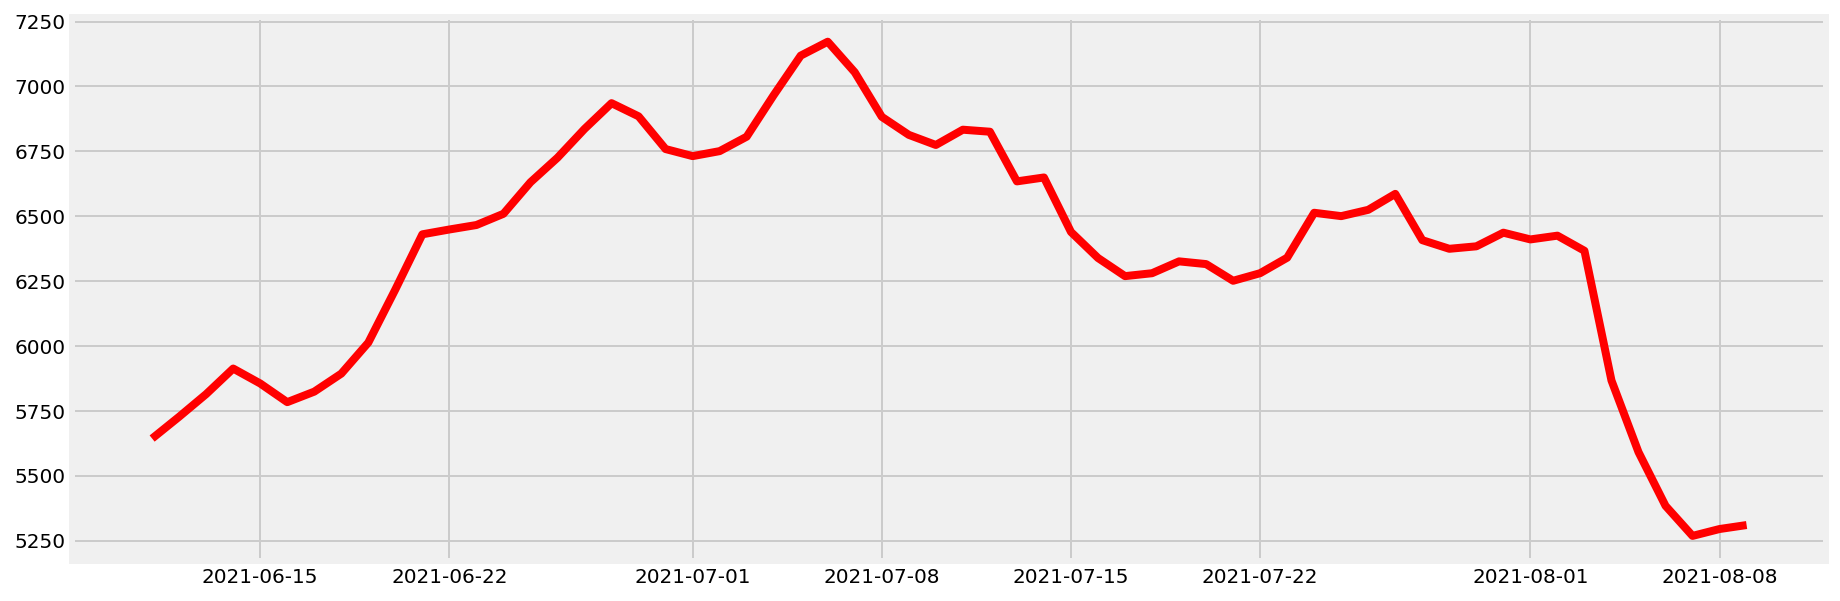

In [20]:
plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE[predict_value], color='r', label='Predicted '+predict_value)
plt.show()